In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
import codecs

In [2]:
!pip3 install torch torchvision torchaudio

In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
from datasets import load_dataset

dataset = load_dataset("rahular/itihasa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.03k [00:00<?, ?B/s]

itihasa.py:   0%|          | 0.00/4.89k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/2.61M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75162 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6149 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11722 [00:00<?, ? examples/s]

In [5]:
from datasets import load_dataset

dataset = load_dataset("rahular/itihasa", split="train")
dataset

Dataset({
    features: ['translation'],
    num_rows: 75162
})

In [6]:
import torch
from datasets import load_dataset

# Loading the Hugging Face dataset
dataset = load_dataset("rahular/itihasa")

# Extracting translations from the dataset
translations = dataset["train"]["translation"]

# Extracing Sanskrit and English sentences from each entry
sn_sentences = [entry["sn"] for entry in translations]
en_sentences = [entry["en"] for entry in translations]

half_dataset_size = len(sn_sentences) // 5
sn_sentences = sn_sentences[:half_dataset_size]
en_sentences = en_sentences[:half_dataset_size]


In [7]:
import pandas as pd
def read_sentences(file_path,num):
    sentences = []

    with open(file_path, 'r') as reader:
        for s in reader:
            if num==1:
                sentences.append(s.strip())
            else:
                sentences.append(codecs.unicode_escape_decode(s)[0].strip())

    return sentences

lines=pd.DataFrame()
lines['san']=sn_sentences
lines['eng']=en_sentences


In [8]:
# Lowercase all characters
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.san=lines.san.apply(lambda x: x.lower())


In [9]:
import re

# Remove quotes
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x))
lines.san=lines.san.apply(lambda x: re.sub("'", '', x))

In [10]:
import string

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.san=lines.san.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [11]:
from string import digits

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.san = lines.san.apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

In [12]:
# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.san=lines.san.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.san=lines.san.apply(lambda x: re.sub(" +", " ", x))

In [13]:
# Add start and end tokens to target sequences
lines.eng = lines.eng.apply(lambda x : 'START_ '+ x + ' _END')

In [14]:
lines.sample(10)

,san,eng
4732,इदं दिव्यं महच्चापं हेमवज्रविभूषितम्। वैष्णवं ...,START_ o foremost of men this mighty celestial...
11626,ते शरैर्बहुभिश्चित्रैस्तीक्ष्णवेगैरलंकृौः। तोम...,START_ they fell to slaughtering monkeys in th...
8823,स तैः पञ्चभिराविद्धः शरैः शिरसि वानरः। उत्पपात...,START_ having been pierced in the head with th...
14815,तत्र वानरयूथानि सुबहूनि वसन्ति च। बहुरत्नसमाकी...,START_ there live many thousand monkeys beside...
7106,तत्तु शीघ्रमतिक्रम्य कान्तारं रोमहर्षणम्। कैला...,START_ speedily passing that desert land capab...
902,सप्तमी चान्वगात् तासां भगीरथरथं तदा। भगीरथोऽपि...,START_ and the seventh followed bhagirathas ca...
280,पुनः प्राप्ते वसन्ते तु पूर्णः संवत्सरोऽभवत्। ...,START_ when after a full one year spring had a...
6051,अपिधाय बिलद्वारं शैलशृङ्गेण तत् तदा॥ तस्माद् द...,START_ then closing up the mouth of the cavern...
4954,एवमुक्त्वा पुनः प्रोचुरालोक्य च परस्परम्॥ चतुर...,START_ having said this they again spoke eyein...
8900,ततः समेतावतितीक्ष्णवेगौ महाबलौ तौ रणनिर्विशङ्क...,START_ thereupon closed in conflict those two ...


In [15]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

print(len(all_eng_words))

18402


In [16]:
all_san_words=set()
for san in lines.san:
    for word in san.split():
        if word not in all_san_words:
            all_san_words.add(word)

print(len(all_san_words))

72422


In [17]:
import numpy as np

# Max Length of source sequence
lenght_list=[]
for l in lines.san:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)

mean_length_src=np.mean(lenght_list)

print(mean_length_src)

11.611029803086748


In [18]:
# Max Length of target sequence
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)

mean_length_tar=np.mean(lenght_list)

print(mean_length_tar)

31.660989888238426


In [19]:
# Sort the list of unique words in both English and Sanskrit
target_words = sorted(list(all_eng_words))
input_words = sorted(list(all_san_words))

# Calculate the number of unique tokens in each language
num_decoder_tokens = len(all_eng_words)
num_encoder_tokens = len(all_san_words)

num_encoder_tokens, num_decoder_tokens

(72422, 18402)

In [20]:
# Increment the number of decoder tokens by 1
num_decoder_tokens += 1

# Create dictionaries to map words to unique indices
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

# Create reverse dictionaries to map indices back to words
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())


In [21]:
from sklearn.utils import shuffle

lines = shuffle(lines)
lines.head(10)

,san,eng
10901,अङ्गदं संप्रधावन्ति प्रजापतिमिव प्रजाः॥ ततो हर...,START_ thereat terrified the monkeys with thei...
13954,प्रहस्तोऽथ दशग्रीवं गत्वा वचनमब्रवीत्। प्रहृष्...,START_ and prahasta going back joyfully spoke ...
718,या चान्या शैलदुहिता कन्याऽऽसीद् रघुनन्दन। उग्र...,START_ the other daughter of the mountain o de...
14374,कामगं स्यन्दनं दिव्यमन्तरिक्षचरं ध्रुवम्। माया...,START_ he has also obtained illusory powers wh...
10584,इन्द्रजित्तु तदानेन निर्जितो भीमकर्मणा। संयुगे...,START_ in the battle field beaten by valrs son...
2383,अथ रामस्तदा श्रुत्वा पितुरातस्य भाषितम्। लक्ष्...,START_ hearing these words of his distressed f...
14009,ततः कृतस्वस्त्ययनो रथमारुह्य रावणः। त्रैलोक्यव...,START_ then having performed svastyayana rāvan...
11656,निर्भिद्य बाणैस्तपनीयवर्णैः। ववर्ष राम शरवृष्ट...,START_ having pierced those foremost monkeys w...
6261,तान् गुणान् सम्प्रधाहमग्र्यं चाभिजनं तव। तारया...,START_ and knowing your high pedigree and all ...
11551,तमापतन्तमुत्पत्य हनूमान्कपिकुञ्जरः॥ आजघान तदा ...,START_ as he rushed on that foremost of monkey...


## **Train and Test Split**

In [22]:
from sklearn.model_selection import train_test_split

# Train - Test Split
X, y =  lines.san, lines.eng
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

# Get the number of samples in each split
X_train.shape, X_test.shape

((13528,), (1504,))

In [23]:
# Combine the corresponding Sanskrit (X) and English (y) sentences in DataFrames
train_df = pd.DataFrame({'san': X_train, 'eng': y_train})
test_df = pd.DataFrame({'san': X_test, 'eng': y_test})

# Save the DataFrames to pickle files
train_df.to_pickle('train_data.pkl')
test_df.to_pickle('test_data.pkl')

# Optional: Check if saved correctly
print(train_df.head())
print(test_df.head())

                                                     san  \
1402   जनकस्य वचः श्रुत्वा पाणीन्पाणिभिरस्पृशन्॥ चत्व...   
8317   चिताधूमाकुलपथा गृध्रमण्डलमण्डिता। अचिरेणैव काल...   
9869   ऋषेः कण्वस्य पुत्रेण कण्डुना परमर्षिणा। शृणु ग...   
3175   तं देशमहमागम्य दीनसत्त्वः सुदुर्मनाः॥ अपश्यमिष...   
10343  चर्यमाणं तपस्तीव्र संतापयति राक्षसान्। देवदानव...   

                                                     eng  
1402   START_ hearing janakas speech those four perpe...  
8317   START_ and in no time shall lankā assume the a...  
9869   START_ do you hear i shall relate a sacred sto...  
3175   START_ hearing in the night the pathetic words...  
10343  START_ the fierce austerities of vowobserving ...  
                                                     san  \
10316  जनन्या राक्षसेन्द्रो वै त्वन्मोक्षार्थं बृहद्व...   
9655   ते रथान्तरचरा एके दृप्तानेके दृढान्हयान्। नागा...   
14715  त्रयाणामेव भूतानां गतिरेषा प्लवंगम। मनोनिलसुपर...   
12445  एष हन्ति गजानीकमेष हन्ति महारथान्। एष 

In [24]:
import tensorflow as tf
import numpy as np

def generate_batch(X, y, batch_size=128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            current_batch_size = min(batch_size, len(X) - j)

            encoder_input_data = np.zeros((current_batch_size, max_length_src), dtype='float32')
            decoder_input_data = np.zeros((current_batch_size, max_length_tar), dtype='float32')
            decoder_target_data = np.zeros((current_batch_size, max_length_tar, num_decoder_tokens), dtype='float32')

            for i, (input_text, target_text) in enumerate(zip(X[j:j + current_batch_size], y[j:j + current_batch_size])):
                # Populate encoder input data
                for t, word in enumerate(input_text.split()):
                    if word in input_token_index:
                        encoder_input_data[i, t] = input_token_index[word]

                # Populate decoder input and target data
                for t, word in enumerate(target_text.split()):
                    if word in target_token_index:
                        if t < len(target_text.split()) - 1:
                            decoder_input_data[i, t] = target_token_index[word]
                        if t > 0:
                            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

            yield (encoder_input_data, decoder_input_data), decoder_target_data

# Define the output signature of your dataset (this ensures TensorFlow understands the shape and type)
def create_tf_dataset(X, y, batch_size=128):
    output_signature = (
        (
            tf.TensorSpec(shape=(None, max_length_src), dtype=tf.float32),
            tf.TensorSpec(shape=(None, max_length_tar), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(None, max_length_tar, num_decoder_tokens), dtype=tf.float32)
    )

    dataset = tf.data.Dataset.from_generator(
        lambda: generate_batch(X, y, batch_size),
        output_signature=output_signature
    )

    return dataset


In [25]:
latent_dim = 50

In [26]:
from keras.layers import Input, LSTM, Embedding, Dense

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [27]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [28]:
from keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 50)       │      3,621,100 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 50)       │        920,150 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 50), (None,    │         20,200 │ embedding[0][0],       │
│                           │ 50), (None, 50)]       │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 50),     │         20,200 │ embedding_1[0][0],     │
│                           │ (None, 50), (None,     │                │ lstm[0][1], lstm[0][2] │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 18403)    │        938,553 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,520,203 (21.06 MB)

 Trainable params: 5,520,203 (21.06 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 32
epochs = 5

In [30]:
# Create datasets for training and validation
train_dataset = create_tf_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_tf_dataset(X_test, y_test, batch_size=batch_size)

# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=val_dataset,
    validation_steps=val_samples // batch_size
)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - accuracy: 0.0030 - loss: 7.6414 - val_accuracy: 0.0039 - val_loss: 6.5310
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - accuracy: 0.0040 - loss: 6.4517 - val_accuracy: 0.0056 - val_loss: 6.3535
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - accuracy: 0.0056 - loss: 6.2470 - val_accuracy: 0.0073 - val_loss: 6.1706
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 616s 1s/step - accuracy: 0.0073 - loss: 6.0417 - val_accuracy: 0.0084 - val_loss: 6.0308
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 617s 1s/step - accuracy: 0.0085 - loss: 5.8690 - val_accuracy: 0.0093 - val_loss: 5.9202


In [31]:
# Corrected filename for saving weights
model.save_weights('nmt_model.weights.h5')


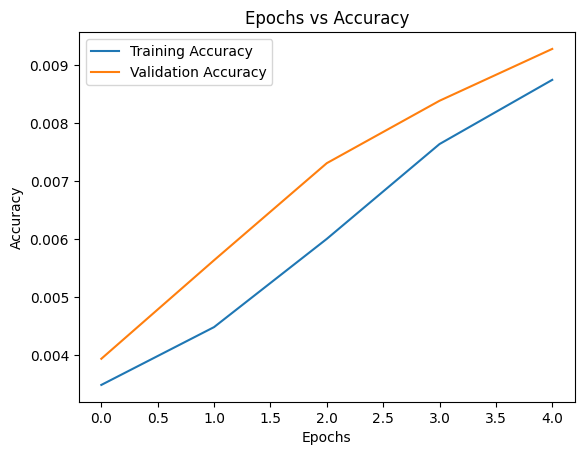

In [32]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.legend()
plt.show()


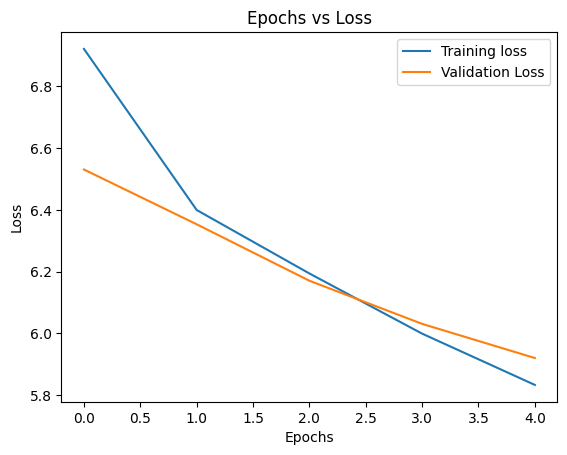

In [33]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Training loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()
plt.show()


In [34]:
# Corrected filename for saving weights
model.save_weights('nmt_model.weights.h5')

In [35]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [36]:
def decode_sequence(input_seq,lenn):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > lenn*(mean_length_tar/mean_length_src)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [37]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1
res_out=np.array([['the sentence in engish','the sanskrit sentence','predicted translation']])

for k in range(1,2):

  (input_seq, actual_output), _ = next(val_gen)
  decoded_sentence = decode_sequence(input_seq,len(X_test[k-1:k].values[0]))
  res_out=np.append(res_out,np.array([[y_test[k-1:k].values[0][7:-5],X_test[k-1:k].values[0],decoded_sentence[1:-5]]]),axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━

In [38]:
res_out

array([['the sentence in engish', 'the sanskrit sentence',
        'predicted translation'],
       ['o vaidehi the rākşasa lord was advised by his mother and the aged counsellors in pregnant words informed with affection having your deliverance for their object',
        'जनन्या राक्षसेन्द्रो वै त्वन्मोक्षार्थं बृहद्वचः। अतिस्निग्धेन वैदेहि मन्त्रिवृद्धेन चोदितः॥',
        'and the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the lord of the lord of the lord of the earth']],
      dtype='<U169')

In [39]:
res_out = np.array(res_out)

original_english_sentences = res_out[1:, 0]  # Skip the header row
predicted_translations = res_out[1:, 2]

accurate_predictions = np.sum(original_english_sentences == predicted_translations)
total_predictions = len(predicted_translations)
accuracy = accurate_predictions / total_predictions

print(f"Accuracy: {accuracy*100:.2f}%")


Accuracy: 63.72%
